## Clusterisation de declaration : Approche Topic model
Dans ce notebook, nous proposons une méthode pour regrouper les signalements identiques. La méthode est la suivante :
- Netoyage des données : stop
- Sélection des colonnes pour le texte
- Mise en forme d'un document : ngrams, lemmatisation, vocabulaire médicale
- Construction d'une représentation vectorielle : tfidf/word_count
- Construction d'une représentation dense :  topic modeling/PCA
- Algorithme de regroupement des representation denses 

Scénario 1 : 
- Suppression des stop word
- Concaténation des Colonnes Description Incident et Etat Patient
- Calcul des 3-gramms, + extraction du fabricant + Lemmatisation + extraction du vocabulaire medicale
- Application d'un count vectorizer
- application d'un LDA
- Algorithme sur la distance de basée sur les thèmes

## 1 chargement des données

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
import yaml
import ast

sys.path.append('/home/robin/Nextcloud/strar_clay/GitLab/signalement-ia/prediction_models/training')

import numpy as np
import pandas as pd
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt



import spacy
import string
import nltk
from spacy.lang.fr.stop_words import STOP_WORDS 

# gensim
import gensim
from gensim import corpora

from time import time
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO,
                   filename='running.log',filemode='w')

from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim import models
import pyLDAvis
import clean_text
from gensim.models import AuthorTopicModel
import pyLDAvis.gensim
from gensim.utils import deaccent

with open(os.path.join('/home/robin/Nextcloud/strar_clay/GitLab/signalement-ia/prediction_models', 'config.yaml'), 'r') as stream:
    config_data = yaml.load(stream, Loader=yaml.FullLoader)

mrv = pd.read_csv(config_data['training']['data']['mrv']['file_path'])

nlp = spacy.load('fr', disable=['parser', 'ner'])#'fr_core_news_md', 'fr_news' diponible également

In [3]:
SAVE_PATH = "/home/robin/Nextcloud/strar_clay/GitLab/Annexe/L3/"

In [4]:
df_test = pd.read_pickle(os.path.join(SAVE_PATH,'cleaned_data.pkl'))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe7 in position 1486: invalid continuation byte

## Quelques fonctions pour le preprocessing et la construction du features textuelles

In [5]:
# Quelques fonction classiques et utiles
def spacy_lemmatisation(text) :
    """
    Transforme le text en une liste de Lemme (la forme du dictionaire d'un mot). 
    Si il n'y a qu'un seul mot on renvoie simplement le lemme
    Entrée:
    - text:type:str, le texte 
    Sortie:
     - lemme:type:list(str), Liste des différents lemmes
    """
    doc = nlp(text)
    if len(doc)>1:
        lemma = [token.lemma_.lower() for token in doc if token.text.lower() not in set(STOP_WORDS)|set(string.punctuation)]
        return(lemma)
    elif len(doc)==1 :
        return(nlp(text)[0].lemma_.lower())
    else :
        return([''])

def nltk_tokenisation(text,sw=True):
    """
    Transforme le texte en liste de tokens, en miniscule, en ayant suprimé la  ponctuatiuon et les mots frequents
    Entrées
    - x::type:str
    Sortie:
    - tokens::type:list(str) liste de tokens
    
    Exemple : Entrée = "je suis heureux aujourd'hui"; Sortie : ['je', 'suis', 'heureux', "aujourd'hui"]
    """
    txt = text.lower()
    if sw==False :
        tokens = nltk.word_tokenize(txt, language='french', preserve_line=False)
    else : 
        words = nltk.word_tokenize(txt, language='french', preserve_line=False)
        tokens = [word for word in words  if word not in set(STOP_WORDS)|set(string.punctuation)]
    return(tokens)

def spacy_extract_pos(text,f='nltk'):
    """
    Fonction qui prend en entrée du texte et qui renvoie au format l'étiquetage morpho-synthaxique du document sous forme de  list(tupple) ou bien d'une dataframe selon la valeur de f.
    Entrées :
    - text::type:str, le texte 
    - f::type:str, peut prendre 'nltk' ou 'pd'
    Sorties :
    - df: Dataframe avec les tags
    - nltk-format::type:list(tuple)
    """
    doc=nlp(text)
    parsed_text = {'word':[], 'upos':[]}
    nltk_format = []
    for wrd in doc:
        parsed_text['word'].append(wrd.text)
        parsed_text['upos'].append(wrd.pos_)
        nltk_format.append((wrd.text,wrd.pos_))
    #return a dataframe of pos and text
    df= pd.DataFrame(parsed_text)
    if f=='nltk':
        return(nltk_format)
    else :
        return(df)
    

def nltk_keyWord(text):
    """
    Fonction qui prend le texte en entrée et renvoie en sortie une liste de mot identifés comme important.
    Les mots importants sont identifés utilisant l'étiquetage morpho-syntaxique de spacy et une expression régulière sur ces étiquettes.
    Entrée:
    - text::type:str, le texte 
    Sortie:
    - keywords::type:list(str())
    """
    tagged = spacy_extract_pos(text,f='nltk')
    keywords = set()
    chunkGram = r"""NE:  {<PROPN>+<PROPN>?|<PROPN|NOUN>+<CC.*|NOUN.*>+<PROPN>}
                {<PROPN>}"""
    chunkParser = nltk.RegexpParser(chunkGram)
    chunked = chunkParser.parse(tagged)
    NE = [" ".join(w for w, t in ele) for ele in chunked if
              isinstance(ele, nltk.Tree)]
    for i in NE:
        keywords.add(i)
    return(keywords)

def rake_key_phrases_extract(text) :
    """
    Utilisant le moteur Rake, cette fonction retourne une liste des phrases
    considérées comme importante.
    Entrées : 
    - text::type:str, le texte 
    Sortie :
    - liste de phrase.
    """
    from multi_rake import Rake
    r = Rake(language_code='fr',stopwords = STOP_WORDS)
    k = r.apply(text)
    K = [l[0] for l in k]
    return K

In [6]:
%%time
#Sélection des colonnes
df = mrv[['NUMERO_DECLARATION','DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT','DCO_ID']]
# gestion des Nan
df[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT']] = df[['DESCRIPTION_INCIDENT','ETAT_PATIENT','FABRICANT']].fillna(' ')
# Construction de la variable textes
df['text'] = df['DESCRIPTION_INCIDENT']+df['ETAT_PATIENT']
# Nettoyage des données textuelles
df['text'] = df['text'].map(lambda x : clean_text.preprocess_text(str(deaccent(x))))
# Construction des lemmes et supressions des stop word
df['text_tok'] = df['text'].map(lambda x :  nltk_tokenisation(str(x)))

df['text_lem'] = df['text'].map(lambda x :  spacy_lemmatisation(str(x)))

df['rake_kw'] = df['text'].map(lambda x : rake_key_phrases_extract(str(x)))

CPU times: user 17min 2s, sys: 2.11 s, total: 17min 4s
Wall time: 17min 8s


In [7]:
%%time
# construction des n grammes avec le modèles de spacy
Docs = df['text_lem'].tolist()
bigram = gensim.models.Phrases(Docs,min_count=1, threshold=2)
trigram = gensim.models.Phrases(bigram[Docs], threshold=2)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

bigrams = [bigram_mod[line] for line in Docs]
df['bigram'] = bigrams

trigrams = [trigram_mod[bigram_mod[line]] for line in Docs]
df['trigram'] = trigrams

CPU times: user 54.6 s, sys: 384 ms, total: 55 s
Wall time: 55.3 s


## Ajout des termes médicaux

In [8]:
med = pd.read_csv(os.path.join(SAVE_PATH,'umls.csv'))

In [9]:
import ast
med_term = med.result.map(lambda x :[elt[0] for elt in ast.literal_eval(x) ])

In [10]:
df['med_term']=med_term
#df.to_csv(os.path.join(SAVE_PATH,'cleaned_data.csv'))

In [11]:
df.to_pickle(os.path.join(SAVE_PATH,'cleaned_data.pkl'))

In [12]:
df_test = pd.read_pickle(os.path.join(SAVE_PATH,'cleaned_data.pkl'))

In [27]:
df['text_fin'] =  df['rake_kw'] + df['trigram']+df['med_term']

In [28]:
df['text_fin'].iloc[0]

['guide',
 'coince',
 'interieur',
 'sonde',
 'bouger',
 'changement',
 'sondechangement',
 'guide_coince',
 'interieur',
 'sonde',
 'bouger',
 'changement_sondechangement',
 'sonde',
 'sonde',
 'sonde',
 'sonde']

In [29]:
%%time
# Création du dictionaire ou chaque uinque terme est associé à un index
Docs = df['text_fin'].tolist()
dictionary = corpora.Dictionary(Docs)
dictionary.filter_extremes(no_below=3, no_above=0.8, keep_n=100000)
dictionary.save(os.path.join(SAVE_PATH,'LDA','dictionary_tokens_test.dict'))

# Conversion de la liste de document en une document-term matrice

# Approiche sac de mots
doc_term_matrix = [dictionary.doc2bow(doc) for doc in Docs]
corpora.MmCorpus.serialize(os.path.join(SAVE_PATH,'LDA','corpus_rake_tri_bow_test.mm'), doc_term_matrix)

# Approiche tf-idf
#tfidf = models.TfidfModel(doc_term_matrix)
#corpus_tfidf = tfidf[doc_term_matrix]
#corpora.MmCorpus.serialize('./LDA/corpus_tokens_tfidf_test.mm', corpus_tfidf)

CPU times: user 15.8 s, sys: 507 ms, total: 16.3 s
Wall time: 18.9 s


## Approche sac de mot

In [3]:
from gensim.corpora import Dictionary,MmCorpus

dictionary = Dictionary.load(os.path.join(SAVE_PATH,'LDA','dictionary_tokens_test.dict'))

doc_term_matrix = MmCorpus(os.path.join(SAVE_PATH,'LDA','corpus_rake_tri_bow_test.mm')) 


Lda = gensim.models.LdaModel
ldamodel = Lda.load(os.path.join(SAVE_PATH,'LDA','lda_model.model'))

In [30]:
%%time
Lda = gensim.models.LdaModel

# Entrainement du modèle
ldamodel = Lda(doc_term_matrix, num_topics=100, id2word = dictionary, passes=4,)

ldamodel.save(os.path.join(SAVE_PATH,'LDA','lda_model.model'))


#prepration pour la visualisation

#data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

#visualisation

#pyLDAvis.enable_notebook()
#pyLDAvis.display(data)

CPU times: user 12min 27s, sys: 5min 12s, total: 17min 39s
Wall time: 8min 44s


In [4]:
%%time
data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/robin/.local/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/robin/.local/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/robin/.local/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/robin/.local/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/robin/.local/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/robin/.local/lib/python3.6/si

In [6]:
pyLDAvis.save_json(data,os.path.join(SAVE_PATH,'LDA','py_vis.json'))

In [8]:
d

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
43    -0.148095 -0.235064       1        1  2.823469
54     0.027133 -0.163124       2        1  2.517071
31    -0.024883 -0.196204       3        1  2.433239
69     0.021691 -0.155588       4        1  2.421633
34    -0.086639 -0.015837       5        1  2.393292
80    -0.161093  0.027518       6        1  2.355095
11     0.031112 -0.187022       7        1  2.352167
6     -0.272318  0.085254       8        1  2.157473
47     0.031816 -0.269507       9        1  2.138576
95     0.018381 -0.133783      10        1  1.891238
40    -0.229046  0.073283      11        1  1.868643
19    -0.253901  0.069415      12        1  1.857688
74     0.055152 -0.130012      13        1  1.841522
92    -0.176138  0.041232      14        1  1.811731
75    -0.146584  0.058432      15        1  1.748031
71    -0.205246  0.024437      16        1  1.684614
81    -0.184323

In [5]:
def topic_document_mat(df,ldamodel,corpus):
    """
    Fonction qui permet de créer la matrice thème documents (les distribution théta dans le modèle de M. blei 2012). Elle repose sur la fonction get_document_topics de gensim().
    Le reste des elemets sont de l'ordre de la mise en forme.
    Entrées :
    - df_brut::type : Pandas dataframe : La dataFrame nettoyé du corpus qui contient au moins les lemmes, le titre, les texte et le nombre d emot de chaque document.
    - ldamodel::type: class model.LDA Gensim: le modèle lda gensim
    - corpus::type:  class corpus Gensim :le corpus associé à ce modèle (l'ordre des document étant le même que celui de df_brut)
    Sorties:
    - df_doc_topic::type: Pandas dataframe: en index, les documents, en colonnes : la proportion de chaque topic, le text, le titre et le Nb_mots.
    """
    doc_lda = ldamodel.get_document_topics(corpus,minimum_probability=0)
    topic_names = ['Topic'+str(i) for i in range(ldamodel.num_topics)]
    
    dist_mat = np.array([np.array([tup[1] for tup in lst]) for lst in doc_lda])
    # Construction de la matrice
    df_doc_topic = pd.DataFrame(dist_mat,columns=topic_names,index=df.index)
    
    # Ajout du numeros de declaration, du texte brut et du  DCO
    #df_doc_topic['NUMERO_DECLARATION']  = df['NUMERO_DECLARATION'].to_list()
    df_doc_topic['text']  = df['text'].to_list()
    df_doc_topic['DCO_ID'] =  df['DCO_ID'].to_list()

    return(df_doc_topic)

In [62]:
ldamodel = gensim.models.LdaModel.load(os.path.join(SAVE_PATH,'LDA','lda_model.model'))
df = pd.read_pickle(os.path.join(SAVE_PATH,'cleaned_data.pkl'))
#df_doc_topic = topic_document_mat(df,ldamodel,doc_term_matrix)

In [5]:
df_doc_htotopic.to_pickle(os.path.join(SAVE_PATH,'doc_topic_mat.pkl'))

NameError: name 'df_doc_topic' is not defined

In [10]:
 %%time
 from sklearn.cluster import DBSCAN

 X = df_doc_topic.iloc[:,0:99].values
 clustering = DBSCAN(eps=3, min_samples=2).fit(X)

In [4]:
 from sklearn.cluster import FeatureAgglomeration,DBSCAN, OPTICS,KMeans
 import pandas as pd
 
 df_doc_topic = pd.read_pickle(os.path.join(SAVE_PATH,'doc_topic_mat.pkl'))

In [7]:
%%time
X = df_doc_topic.iloc[:,0:99].values
agglo = KMeans(150)
agglo.fit(X)


CPU times: user 7min 21s, sys: 3min 27s, total: 10min 48s
Wall time: 3min 37s


KMeans(n_clusters=150)

In [1]:
agglo.cluster_centers_

NameError: name 'agglo' is not defined

In [9]:
from sklearn import metrics
labels = agglo.labels_
print(metrics.silhouette_score(X, labels, metric='euclidean')) #Plus c'est grand plus c'est séparé

0.07858699


In [10]:
print(metrics.calinski_harabasz_score(X, labels)) # Plus c'est grand mieux c'est

709.2850304844015


In [12]:
print(metrics.davies_bouldin_score(X, labels)) # Meilleur llorsque c'est plus proche de 0

2.4800540176290737


In [18]:
df_doc_topic['cluster'] = agglo.labels_

group = df_doc_topic.groupby('cluster')


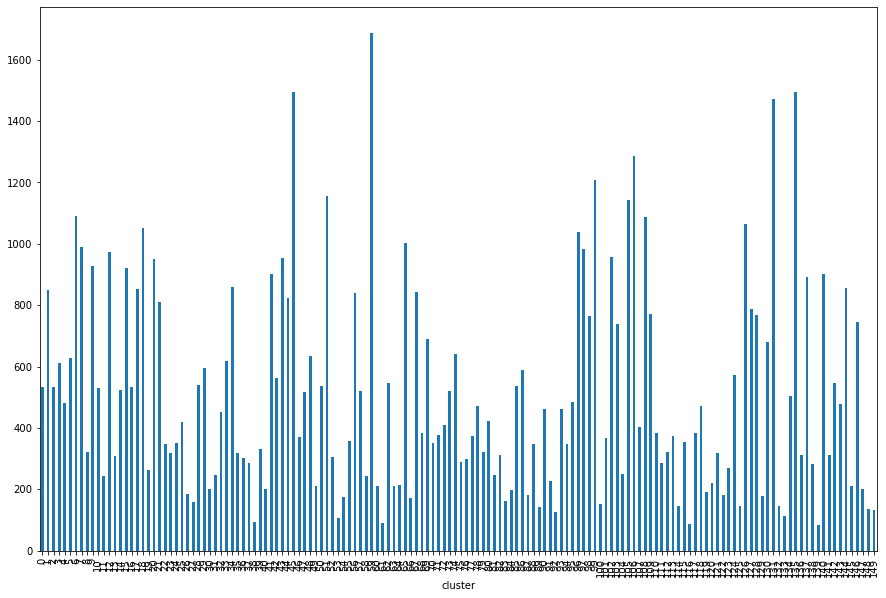

In [32]:
group.count()['Topic1'].plot(kind='bar', figsize = (15,10))


In [38]:
def get_significant_topic(x,seuil):
    return np.where(x>seuil)

In [76]:
from collections import Counter
PREPRO_PATH = '/home/robin/Nextcloud/strar_clay/GitLab/signalement-ia/demonstrateur/data'
id_to_dco = pd.read_csv(os.path.abspath(PREPRO_PATH+"/referentiel_dispositif.csv"), delimiter=';', encoding='ISO-8859-1')

def get_best_topic(df_group):
    T = df_group.iloc[:,0:99].apply(lambda x: get_significant_topic(x,0.1), axis=1)
    topic = np.concatenate(T.values,axis=1)
    c = pd.DataFrame.from_dict(Counter(topic[0]),orient='index',columns=['count'])
    most_frequent_topic = c.sort_values(by='count',ascending=False).iloc[:5].index
    words=[]
    for elt in most_frequent_topic :
        words.append([ x[0] for x in ldamodel.show_topic(elt)])
    return words

def get_best_DCO(df_group):
    c = df_group.groupby('DCO_ID').count()['Topic0']
    most_frequent_dco = c.sort_values(ascending=False).iloc[:5].index
    
    dcos = []
    for elt in most_frequent_dco :
        dco = id_to_dco[id_to_dco['DCO_ID'] == int(elt)]['LIBELLE'].iloc[0]
        dcos.append(dco)

    return dcos

for elt in group.groups :
    df_group = group.get_group(elt)
    print(get_best_topic(df_group))
    print(get_best_DCO(df_group))
    break

[['perfusion', 'pompe', 'reperfusion', 'heure', 'patient', 'matin', 'chambre', 'sortie', 'passer', 'nuit'], ['tubulure', 'fuite', 'patient', 'niveau', 'administration', 'poche', 'auto-administration', 'robinet', 'ide', 'fonctionnel'], ['bloc', 'preparation', 'morceau', 'tombe', 'vagin', 'clou', 'unite', 'face', 'jeune', 'gravite'], ['  ', ' ', 'lot', 'cas', 'controle', 'essai', 'test', 'laboratoire', 'agit', 'patient'], ['catheter', 'pose', 'pansement', 'patient', 'ecoulement', 'voie', 'reflux', 'radiographie', 'conditionnement', 'poser']]
['PERFUSEUR', 'DIFFUSEUR PORTABLE NON REUTILISABLE', 'POMPE A PERFUSION ( TUBULURE )', 'PROLONGATEUR', 'RAMPE DE ROBINET POUR LIGNE DE PERFUSION']


## Approche tfidf

In [57]:
Lda = gensim.models.ldamulticore.LdaMulticore

# Entrainement du modèle
ldamodel_tfidf = Lda(corpus_tfidf, num_topics=100, id2word = dictionary, passes=15)

#prepration pour la visualisation

data_tfidf = pyLDAvis.gensim.prepare(ldamodel_tfidf, corpus_tfidf, dictionary)

#visualisation

pyLDAvis.enable_notebook()
pyLDAvis.display(data_tfidf)

In [74]:
ldamodel_tfidf.save('./LDA/tfidf_model.model')

## Commentaire pour les deux precedentes visualisation
Les visualisations précedentes indiquent qu'une construction des représentations par sac de mot permet une meilleure distinction des clusteurs. Toutefois, avec mes connaissances non métier il me semble difficile de juger de la qualité de cette représentation....

## Integration du DCO pour la construction du topic model

In [59]:
df['index'] = np.arange(0,len(df))
A2C  = df.groupby(['DCO_ID']).agg({'index':lambda x: list(set(x))})
Author2Doc = A2C.to_dict(orient='dict')['index']

In [61]:
Lda_A = gensim.models.AuthorTopicModel
ldamodel_A = Lda_A(doc_term_matrix,author2doc=Author2Doc, num_topics=100, id2word = dictionary, passes=15)

In [62]:
ldamodel_A.save('./LDA/authorTopic.model')

In [70]:
from pprint import pprint
pprint(ldamodel_A.print_topics())

[(67,
  '0.043*"hospitalisation" + 0.033*"remplissage" + 0.019*"hanche gauche" + '
  '0.018*"re-hospitalisation" + 0.016*"urgences" + 0.014*"basculé" + '
  '0.012*"chutes" + 0.011*"chute" + 0.010*"remplissage_diffuseur" + '
  '0.008*"expliquée"'),
 (23,
  '0.027*"tete" + 0.023*"tête" + 0.021*"table" + 0.021*"moteur" + '
  '0.017*"trepan" + 0.017*"sac" + 0.013*"saignement" + 0.010*"optimale" + '
  '0.010*"derealisation" + 0.010*"dure_mère"'),
 (87,
  '0.022*"/ /" + 0.015*"niveau" + 0.013*"patiente" + 0.011*"suite" + '
  '0.010*"présence" + 0.010*"retrouvé" + 0.009*"hematome" + 0.009*"reprise" + '
  '0.009*"présente" + 0.007*"accident"'),
 (8,
  '0.098*"saignement" + 0.032*"retiré" + 0.030*"malaise" + 0.014*"prurit" + '
  '0.014*"palpation" + 0.014*"crochet" + 0.012*"août" + 0.012*"monté" + '
  '0.011*"tronc" + 0.011*"cassées"'),
 (75,
  '0.017*"pose" + 0.011*"consultation" + 0.010*"regle" + 0.010*"regles" + '
  '0.009*"douleurs" + 0.008*"pression" + 0.008*"migraine" + 0.008*"implante" +

In [63]:
#author_vecs = [ldamodel.get_author_topics(author) for author in ldamodel.id2author.values()]
#import pyLDAvis.gensim
#import gensim.models.atmodel as atmodel
#doc2author = atmodel.construct_doc2author(ldamodel.corpus, ldamodel.author2doc)
#gamma, _ = ldamodel.inference(ldamodel.corpus, ldamodel.author2doc, doc2author, 0)

## Hierachical topic model 

In [72]:

Hdp_model = gensim.models.hdpmodel.HdpModel(corpus=doc_term_matrix, id2word=dictionary)
Hdp_model.save('./LDA/HdpTopic.model')

In [76]:
pprint(Hdp_model.print_topics(100))

[(0,
  '0.014*patient + 0.008*pose + 0.007*prothese + 0.006*sonde + 0.005*catheter '
  '+ 0.005*patiente + 0.005*niveau + 0.005*retraite + 0.005*aiguille + '
  '0.004*re-intervention'),
 (1,
  '0.010*pose + 0.008*patient + 0.005*retraite + 0.004*patiente + '
  '0.004*implante + 0.004*niveau + 0.003*probleme + 0.003*/ / + 0.003*douleurs '
  '+ 0.003*pression'),
 (2,
  '0.014*ventre + 0.010*crise + 0.009*pose + 0.008*consultation + '
  '0.008*douloureux + 0.007*gorge + 0.007*regle + 0.007*regles + 0.007*douleur '
  'musculaire + 0.006*radio'),
 (3,
  '0.011*pose + 0.009*pression + 0.009*migraine + 0.008*ventre + '
  '0.008*probleme + 0.008*cheveux + 0.007*retraite + 0.006*implante + '
  '0.006*douleur articulaire + 0.006*regle'),
 (4,
  '0.009*patient + 0.008*prothese + 0.007*pose + 0.005*retraite + '
  '0.005*patiente + 0.004*catheter + 0.004*re-intervention + 0.004*implante + '
  '0.003*/ / + 0.003*probleme'),
 (5,
  '0.011*migraine + 0.011*regle + 0.010*regles + 0.009*pose + 0.008*ven

## Comparons les différents modèles 
link : https://radimrehurek.com/gensim/auto_examples/howtos/run_compare_lda.html

In [2]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [3]:
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""
    import plotly.graph_objs as go
    import plotly.offline as py

    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))


def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.title(title)
    plt.colorbar(data)


try:
    get_ipython()
    import plotly.offline as py
    py.init_notebook_mode()
except Exception:
    #
    # Fall back to matplotlib if we're not in a notebook, or if plotly is
    # unavailable for whatever reason.
    #
    plot_difference = plot_difference_matplotlib
else:
    py.init_notebook_mode()
    plot_difference = plot_difference_plotly

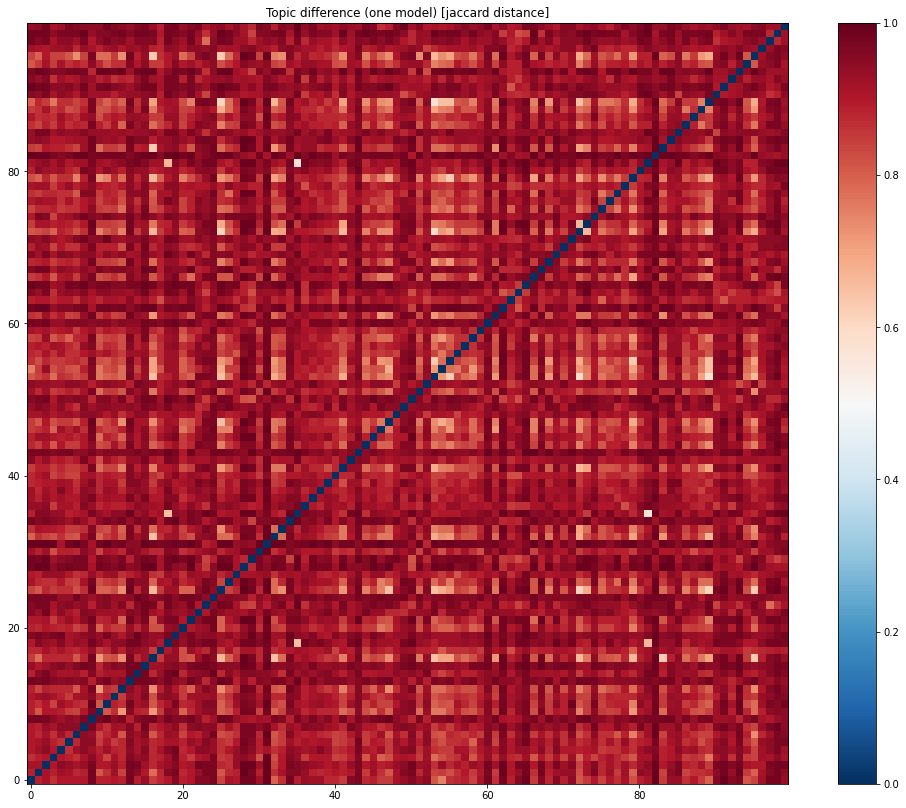

In [9]:
Lda = gensim.models.ldamulticore.LdaMulticore
ldamodel = Lda.load('./LDA/lda_model.model')
mdiff, annotation = ldamodel.diff(ldamodel, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

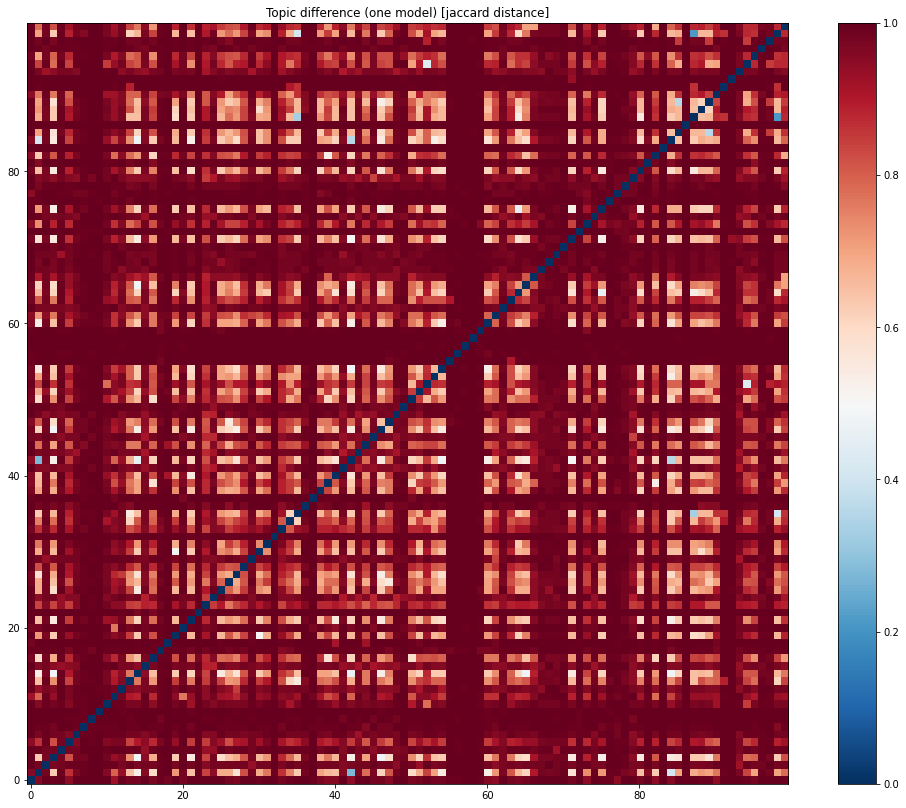

In [16]:
Lda = gensim.models.ldamulticore.LdaMulticore
ldamodel_tfidf = Lda.load('./LDA/tfidf_model.model')
mdiff, annotation = ldamodel_tfidf.diff(ldamodel_tfidf, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

In [15]:
Lda = gensim.models.hdpmodel.HdpModel
ldamodel_hdp = Lda.load('./LDA/HdpTopic.model')
mdiff, annotation = ldamodel_hdp.diff(ldamodel_hdp, distance='jaccard', num_words=50)
plot_difference_matplotlib(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

AttributeError: 'HdpModel' object has no attribute 'diff'